## Predicting Bitcoin Price using LSTM 

In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username":"xxxxxx","key":"xxxxxxxxxxxxxxxxxxx"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d mczielinski/bitcoin-historical-data -p/content

bitcoin-historical-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip \*.zip

Archive:  bitcoin-historical-data.zip
replace bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv  
  inflating: coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv  


In [10]:
import pandas as pd
bit_data = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv")
bit_data.head(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()
data.head(5)

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

In [ ]:
train=data.iloc[:len(data)-60]
test=data.iloc[len(train):]

In [ ]:
train = train.to_frame()
test = test.to_frame()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
train_sc = sc.fit_transform(train)

In [35]:
import numpy as np
timestep=60
x_train=[]
y_train=[]

for i in range(timestep,train_sc.shape[0]):
    x_train.append(train_sc[i-timestep:i,0])
    y_train.append(train_sc[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train :  ",x_train.shape)
print("y_train : ",y_train.shape)

x_train :   (2659, 60, 1)
y_train :  (2659,)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

regressor = Sequential()
regressor.add(LSTM(10, input_shape = (None,1), activation='relu'))

In [ ]:
regressor.add(Dense(units=1))

In [50]:
regressor.compile(loss="mean_squared_error",optimizer="adam")
regressor.fit(x_train,y_train,epochs=100,batch_size=32)

W0901 08:16:32.316384 139950164748160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0901 08:16:32.740763 139950164748160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/100
2659/2659 [==============================] - 3s 1ms/step - loss: 4.5409
Epoch 2/100
2659/2659 [==============================] - 3s 987us/step - loss: 0.0096
Epoch 3/100
2659/2659 [==============================] - 3s 984us/step - loss: 0.0097
Epoch 4/100
2659/2659 [==============================] - 3s 969us/step - loss: 0.0094
Epoch 5/100
2659/2659 [==============================] - 3s 967us/step - loss: 0.0091
Epoch 6/100
2659/2659 [==============================] - 3s 962us/step - loss: 0.0088
Epoch 7/100
2659/2659 [==============================] - 3s 976us/step - loss: 0.0084
Epoch 8/100
2659/2659 [==============================] - 3s 981us/step - loss: 0.0081
Epoch 9/100
2659/2659 [==============================] - 3s 982us/step - loss: 0.0077
Epoch 10/100
2659/2659 [==============================] - 3s 999us/step - loss: 0.0074
Epoch 11/100
2659/2659 [==============================] - 3s 984us/step - loss: 0.0071
Epoch 12/100
2659/2659 [==============================

In [ ]:
inputs=data[len(data)-len(test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=sc.transform(inputs)

In [ ]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [ ]:
predicted=regressor.predict(x_test)
predicted=sc.inverse_transform(predicted)

In [ ]:
test=np.array(test)
test=test.reshape(len(test),1)

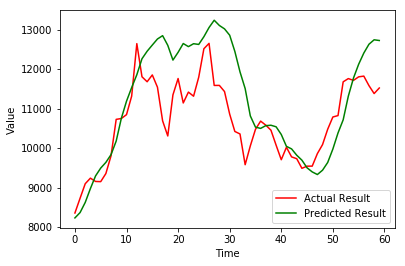

In [64]:
import matplotlib.pyplot as plt
plt.plot(test,color="r",label="Actual Result")
plt.plot(predicted,color="g",label="Predicted Result")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()